We are sorry but the final version of the code used for the report got deleted so we had to rewrite some of the code. Some of the graphs and models may not be exactly the same as the final report. 

Also, the committee20.txt file was too large for us to submit on gradescope, to run the code you need to download the 2019-2020 csv from the candidate-committee linkages tab on https://www.fec.gov/data/browse-data/?tab=bulk-data

In [82]:
%pip install statsmodels


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [83]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.gridspec as gridspec

In [84]:
cand_summary_cols = [
    "CAND_ID",
    "CAND_NAME",
    "CAND_ICI",
    "PTY_CD",
    "CAND_PTY_AFFILIATION",
    "TTL_RECEIPTS",
    "TRANS_FROM_AUTH",
    "TTL_DISB",
    "TRANS_TO_AUTH",
    "COH_BOP",
    "COH_COP",
    "CAND_CONTRIB",
    "CAND_LOANS",
    "OTHER_LOANS",
    "CAND_LOAN_REPAY",
    "OTHER_LOAN_REPAY",
    "DEBTS_OWED_BY",
    "TTL_INDIV_CONTRIB",
    "CAND_OFFICE_ST",
    "CAND_OFFICE_DISTRICT",
    "SPEC_ELECTION",
    "PRIM_ELECTION",
    "RUN_ELECTION",
    "GEN_ELECTION",
    "GEN_ELECTION_PERCENT",
    "OTHER_POL_CMTE_CONTRIB",
    "POL_PTY_CONTRIB",
    "CVG_END_DT",
    "INDIV_REFUNDS",
    "CMTE_REFUNDS"
]


master_cols = [
    "CAND_ID", 
    "CAND_NAME", 
    "CAND_PTY_AFFILIATION", 
    "CAND_ELECTION_YR", 
    "CAND_OFFICE_ST", 
    "CAND_OFFICE", 
    "CAND_OFFICE_DISTRICT", 
    "CAND_ICI", 
    "CAND_STATUS", 
    "CAND_PCC", 
    "CAND_ST1", 
    "CAND_ST2", 
    "CAND_CITY", 
    "CAND_ST", 
    "CAND_ZIP"
]

committee_cols = [
    "CAND_ID",
    "CAND_ELECTION_YR",
    "FEC_ELECTION_YR",
    "CMTE_ID",
    "CMTE_TP",
    "CMTE_DSGN",
    "LINKAGE_ID"
]

cand_summary = pd.read_csv('/Users/jackkwon/Desktop/Data 102 Final Project/cand_summary20.txt', sep = '|', names = cand_summary_cols)
master = pd.read_csv('/Users/jackkwon/Desktop/Data 102 Final Project/cand_master20.txt', sep = '|', names = master_cols)
committee = pd.read_csv('/Users/jackkwon/Desktop/Data 102 Final Project/committee20.txt', sep = '|', names = committee_cols)

In [85]:
#Joining all tables into one, for the sake of GLM logistic regression, should merge C And O into one category 
df1 = cand_summary.merge(master, on = 'CAND_ID', suffixes=('', '_DROP'))
df = df1.merge(committee, on = 'CAND_ID', suffixes=('', '_DROP'))
df = df.loc[:, ~df.columns.str.endswith('_DROP')]
df = df.drop(columns=['SPEC_ELECTION', 'PRIM_ELECTION', 'RUN_ELECTION', 'GEN_ELECTION', 'GEN_ELECTION_PERCENT'])
df['CAND_ICI'] = df['CAND_ICI'].replace('O', 'C')
df['target'] = df['CAND_ICI'].map({'I':1, 'C':0})
df['CAND_PTY_AFFILIATION'] = df['CAND_PTY_AFFILIATION'].apply(lambda x: x if x in ['DEM', 'REP'] else 'Other')
df['CAND_OFFICE_ENCODED'] = df['CAND_OFFICE'].apply(lambda x: 1 if x == 'P' else 0)
df['CMTE_DSGN_ENCODED'] = df['CMTE_DSGN'].apply(lambda x: 1 if x in ['A', 'P'] else 0)

Text(0.5, 1.0, 'Number of Nulls per Column')

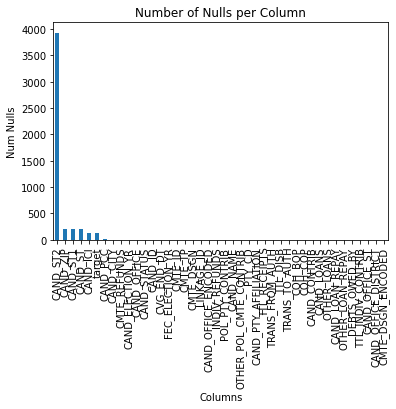

In [86]:
null_cols = df.isnull().sum().sort_values(ascending=False)
null_cols.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Num Nulls')
plt.title('Number of Nulls per Column')

In [87]:
#Trying to predict CAND_ICI column, so filter out Columns with Null Values
df = df[~df['CAND_ICI'].isnull()]
contribution_columns = [col for col in df.columns if col.endswith('CONTRIB')]
df['total_contributions'] = df[contribution_columns].sum(axis=1)
df['arcsin_total_contributions'] = np.arcsinh(df['total_contributions'])

EDA

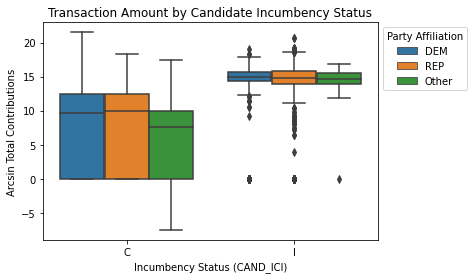

In [88]:
# CODE FOR FIGURE 1
sns.boxplot(data=df, x='CAND_ICI', y='arcsin_total_contributions', hue = 'CAND_PTY_AFFILIATION')
plt.title('Transaction Amount by Candidate Incumbency Status')
plt.xlabel('Incumbency Status (CAND_ICI)')
plt.ylabel('Arcsin Total Contributions')
plt.legend(title='Party Affiliation', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


Text(0.5, 1.0, 'Arcsin Total Contributions by Race Type')

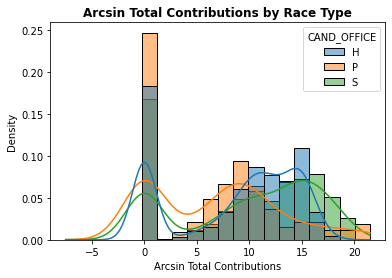

In [89]:
#Show relationship between Race Type and Total Contributions 
sns.histplot(data = df, x = 'arcsin_total_contributions', hue = 'CAND_OFFICE', stat = 'density', bins = 20, kde = True, common_norm = False)
plt.xlabel('Arcsin Total Contributions')
plt.title('Arcsin Total Contributions by Race Type', fontweight = 'bold')

Text(0.5, 1.0, 'Arcsin Total Contributions by Incumbency Status')

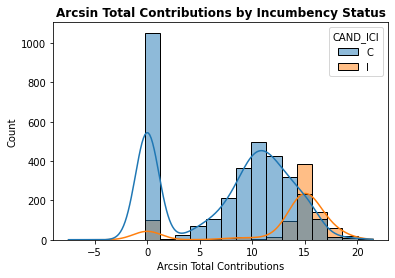

In [90]:
#CODE FOR FIGURE 2
sns.histplot(data = df, x = 'arcsin_total_contributions', hue = 'CAND_ICI', bins = 20, kde = True, common_norm = False)
plt.xlabel('Arcsin Total Contributions')
plt.title('Arcsin Total Contributions by Incumbency Status', fontweight = 'bold')

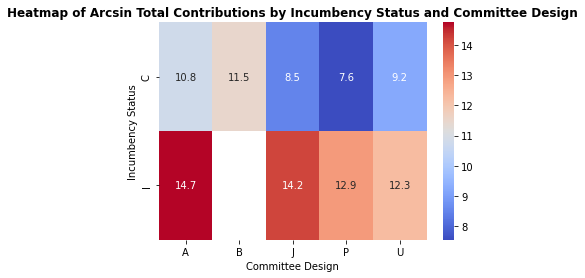

In [91]:
heatmap_data1 = df.pivot_table(values='arcsin_total_contributions', index='CAND_ICI', columns='CMTE_DSGN', aggfunc='mean')

# Plot the heatmap
sns.heatmap(heatmap_data1, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Heatmap of Arcsin Total Contributions by Incumbency Status and Committee Design', fontweight = 'bold')
plt.xlabel('Committee Design')
plt.ylabel('Incumbency Status')
plt.show()

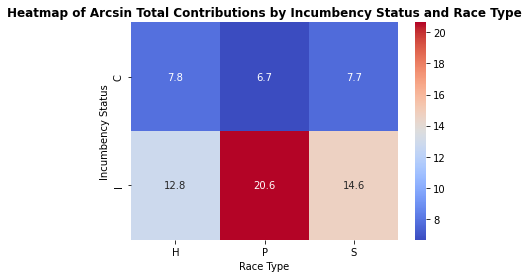

In [92]:
heatmap_data2 = df.pivot_table(values='arcsin_total_contributions', index='CAND_ICI', columns='CAND_OFFICE', aggfunc='mean')

# Plot the heatmap
sns.heatmap(heatmap_data2, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Heatmap of Arcsin Total Contributions by Incumbency Status and Race Type', fontweight = 'bold')
plt.xlabel('Race Type')
plt.ylabel('Incumbency Status')
plt.show()

GLM + RANDOM FOREST

In [93]:
features = ['COH_BOP', 'total_contributions', 'CMTE_DSGN_ENCODED', 'CAND_LOANS', 'POL_PTY_CONTRIB']
X = df[features]
X = sm.add_constant(X)
y = df['target']

Correlation Matrix:
                     const   COH_BOP  total_contributions  CMTE_DSGN_ENCODED  \
const                  NaN       NaN                  NaN                NaN   
COH_BOP                NaN  1.000000             0.268141          -0.268332   
total_contributions    NaN  0.268141             1.000000          -0.104680   
CMTE_DSGN_ENCODED      NaN -0.268332            -0.104680           1.000000   
CAND_LOANS             NaN -0.013898             0.067502           0.014063   
POL_PTY_CONTRIB        NaN  0.185068             0.157609          -0.186123   

                     CAND_LOANS  POL_PTY_CONTRIB  
const                       NaN              NaN  
COH_BOP               -0.013898         0.185068  
total_contributions    0.067502         0.157609  
CMTE_DSGN_ENCODED      0.014063        -0.186123  
CAND_LOANS             1.000000         0.028669  
POL_PTY_CONTRIB        0.028669         1.000000  


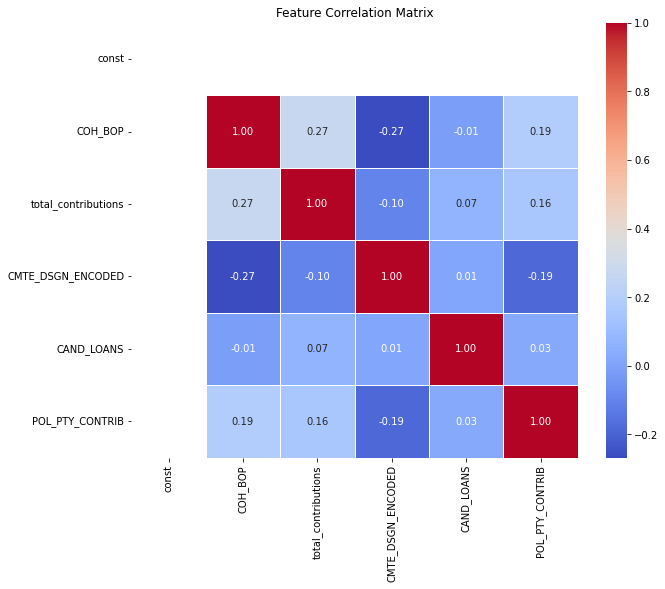

In [94]:
#CODE FOR FIGURE 5
X_corr = X.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(X_corr)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(X_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

In [95]:
#CODE FOR FIGURE 6
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
smote = SMOTE(random_state = 42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


model = sm.GLM(y_train, X_train, family=sm.families.Binomial(link=sm.families.links.Logit()))
results = model.fit()

print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                 3005
Model:                            GLM   Df Residuals:                     2999
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1013.5
Date:                Tue, 17 Dec 2024   Deviance:                       2027.1
Time:                        10:22:52   Pearson chi2:                 9.31e+06
No. Iterations:                     8   Pseudo R-squ. (CS):             0.2750
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.2679    

In [96]:
#Predicting y
y_pred_prob = results.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

In [97]:
#CODE FOR FIGURE 6
#Printing Accuracy 
print('Accuracy:', accuracy_score(y_test, y_pred))

#Printing Classification Report 
print("Classification Report:\n", classification_report(y_test, y_pred))

#Printing Confusion Matrix 
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

Accuracy: 0.8906128782001551
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.98      0.93      1033
         1.0       0.88      0.52      0.66       256

    accuracy                           0.89      1289
   macro avg       0.88      0.75      0.80      1289
weighted avg       0.89      0.89      0.88      1289

Confusion Matrix:
 [[1014   19]
 [ 122  134]]


In [98]:
#CODE FOR FIGURE 6
X_train_smote_glm = sm.add_constant(X_train_resampled)
X_test_smote_glm = sm.add_constant(X_test)

# Fit the GLM on SMOTE data
glm_smote = sm.GLM(y_train_resampled, X_train_smote_glm, family=sm.families.Binomial(link=sm.families.links.Logit()))
glm_smote_results = glm_smote.fit()

# Predict probabilities
y_pred_glm_smote_prob = glm_smote_results.predict(X_test_smote_glm)
y_pred_glm_smote = (y_pred_glm_smote_prob > 0.5).astype(int)

In [99]:
print('GLM Results (SMOTE):\n', glm_smote_results.summary())


GLM Results (SMOTE):
                  Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                 4818
Model:                            GLM   Df Residuals:                     4812
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2003.1
Date:                Tue, 17 Dec 2024   Deviance:                       4006.1
Time:                        10:22:52   Pearson chi2:                 2.69e+12
No. Iterations:                    10   Pseudo R-squ. (CS):             0.4258
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const       

In [100]:
# CODE FOR FIGURE 6
print("\nAccuracy (SMOTE):", accuracy_score(y_test, y_pred_glm_smote))
print("\nClassification Report (SMOTE):")
print(classification_report(y_test, y_pred_glm_smote))
print("Confusion Matrix (SMOTE):")
print(confusion_matrix(y_test, y_pred_glm_smote))


Accuracy (SMOTE): 0.91311093871218

Classification Report (SMOTE):
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95      1033
         1.0       0.82      0.72      0.77       256

    accuracy                           0.91      1289
   macro avg       0.88      0.84      0.86      1289
weighted avg       0.91      0.91      0.91      1289

Confusion Matrix (SMOTE):
[[993  40]
 [ 72 184]]


In [101]:
#Random Forest Model 
rf_model = RandomForestClassifier(random_state = 420)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_pred_prob = rf_model.predict_proba(X_test)[:, 1]

rf_smote = RandomForestClassifier(random_state=42)
rf_smote.fit(X_train_resampled, y_train_resampled)

y_pred_smote = rf_smote.predict(X_test)
y_pred_smote_prob = rf_smote.predict_proba(X_test)[:, 1]

Random Forest Accuracy: 0.9456943366951125
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1033
         1.0       0.86      0.86      0.86       256

    accuracy                           0.95      1289
   macro avg       0.91      0.91      0.91      1289
weighted avg       0.95      0.95      0.95      1289

Confusion Matrix:
 [[998  35]
 [ 35 221]]
Feature Importance Summary:
               Feature  Importance
1              COH_BOP    0.588328
2  total_contributions    0.277651
3    CMTE_DSGN_ENCODED    0.050578
4           CAND_LOANS    0.043829
5      POL_PTY_CONTRIB    0.039614
0                const    0.000000


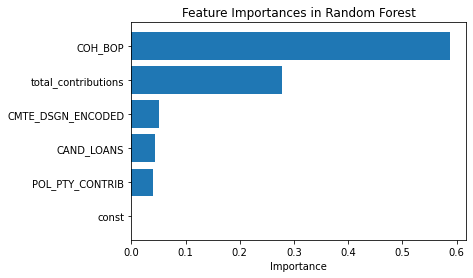

In [102]:
#CODE FOR FIGURE 7
#Random Forest Accuracy 
print('Random Forest Accuracy:', accuracy_score(y_test, rf_pred))

#Classification Report 
print('Classification Report:\n', classification_report(y_test, rf_pred))

#Confusion Matrix 
print('Confusion Matrix:\n', confusion_matrix(y_test, rf_pred))

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importance Summary:")
print(feature_importances)

# Plot feature importance
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances in Random Forest')
plt.gca().invert_yaxis()
plt.show()

Random Forest Accuracy (SMOTE): 0.9379363847944143
Classification Report (SMOTE):
              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96      1033
         1.0       0.80      0.92      0.85       256

    accuracy                           0.94      1289
   macro avg       0.89      0.93      0.91      1289
weighted avg       0.94      0.94      0.94      1289

Confusion Matrix (SMOTE):
[[974  59]
 [ 21 235]]
Feature Importance Summary:
               Feature  Importance
1              COH_BOP    0.587782
2  total_contributions    0.256243
3    CMTE_DSGN_ENCODED    0.075409
4           CAND_LOANS    0.044092
5      POL_PTY_CONTRIB    0.036474
0                const    0.000000


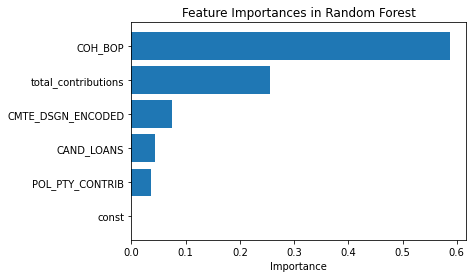

In [103]:
#CODE FOR FIGURE 7
accuracy = accuracy_score(y_test, y_pred_smote)
print(f"Random Forest Accuracy (SMOTE): {accuracy}")

# Classification report and confusion matrix
print("Classification Report (SMOTE):")
print(classification_report(y_test, y_pred_smote))

print("Confusion Matrix (SMOTE):")
print(confusion_matrix(y_test, y_pred_smote))

# Feature importance
feature_importances_smote = pd.DataFrame({
    'Feature': X_train_resampled.columns,
    'Importance': rf_smote.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importance Summary:")
print(feature_importances_smote)

# Plot feature importance
plt.barh(feature_importances_smote['Feature'], feature_importances_smote['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances in Random Forest')
plt.gca().invert_yaxis()
plt.show()


CAUSALITY

In [104]:
dems = pd.read_csv('dem_candidates.csv')
dems.head()

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Biden Endorsed?,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?
0,Anthony White (Alabama),AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,NaN,NaN,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Christopher Countryman,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,NaN,NaN,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Doug ""New Blue"" Smith",AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,NaN,NaN,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,James C. Fields,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,NaN,NaN,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sue Bell Cobb,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,NaN,NaN,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
#CODE FOR FIGURE 8
yes_no_cols = ['Veteran?', 'LGBTQ?', 'Elected Official?', 'Self-Funder?', 'STEM?', 'Obama Alum?', 'Party Support?',
               'Emily Endorsed?', 'Guns Sense Candidate?', 'Biden Endorsed?', 'Sanders Endorsed?',
               'Our Revolution Endorsed?', 'Justice Dems Endorsed?', 'PCCC Endorsed?', 'Indivisible Endorsed?',
               'WFP Endorsed?', 'VoteVets Endorsed?', 'No Labels Support?', 'Won Primary']
#Replace values
yes_no_map = {'Yes': 1, 'No': 0}
for col in yes_no_cols:
  dems[col] = dems[col].map(yes_no_map)

#Binarize race column
dems['White?'] = dems['Race'].map({'White': 1, 'Nonwhite': 0})
yes_no_cols.append('White?')
#Explore NA values
for col in yes_no_cols:
  print(f'Number of null values in column {col}: {len(dems[dems[col].isna()])}')

Number of null values in column Veteran?: 11
Number of null values in column LGBTQ?: 11
Number of null values in column Elected Official?: 11
Number of null values in column Self-Funder?: 0
Number of null values in column STEM?: 11
Number of null values in column Obama Alum?: 1
Number of null values in column Party Support?: 673
Number of null values in column Emily Endorsed?: 583
Number of null values in column Guns Sense Candidate?: 438
Number of null values in column Biden Endorsed?: 772
Number of null values in column Sanders Endorsed?: 782
Number of null values in column Our Revolution Endorsed?: 488
Number of null values in column Justice Dems Endorsed?: 612
Number of null values in column PCCC Endorsed?: 756
Number of null values in column Indivisible Endorsed?: 671
Number of null values in column WFP Endorsed?: 707
Number of null values in column VoteVets Endorsed?: 714
Number of null values in column No Labels Support?: 797
Number of null values in column Won Primary: 22
Numbe

In [106]:
#There are 22 missing Won Primary values.
#Imputing Won Primary = 0 for all candidates with Primary Status = 'Lost', since it is impossible to
#win a primary without advancing.

dems['Won Primary'] = np.where(dems['Primary Status'] == 'Lost', 0, dems['Won Primary'])
#There are 8 other candidates that advanced to a runoff but have a general status = 'On The Ballot'.

#After researching the true status of these 8 candidates (all from OK) on Ballotpedia, we will impute their results.
advanced_and_lost_runoff = ['Amanda Douglas', 'Clay Padgett', 'Fred Gipson', 'Tom Guild']
advanced_and_won_runoff = ['Tim Gilpin', 'Jason Nichols', 'Mary Brannon', 'Kendra Horn']

#Impute their true statuses
dems['Won Primary'] = np.where(dems['Candidate'].isin(advanced_and_lost_runoff), 0, dems['Won Primary'])
dems['Won Primary'] = np.where(dems['Candidate'].isin(advanced_and_won_runoff), 1, dems['Won Primary'])
print(f"Number of Null Won Primary values after imputing: {len(dems[dems['Won Primary'].isna()])}")

#Remove special elections, drop rows with null values in important columns
dems = dems[dems['Race Type'] == 'Regular']

#Choosing columns with the lowest number of null values.
fav_cols = ['Veteran?', 'LGBTQ?', 'Elected Official?', 'Self-Funder?', 'STEM?', 'Obama Alum?']
len_dems_before_dropping = len(dems)
dems = dems.dropna(subset=fav_cols)
len_dems_after_dropping = len(dems)
print(f'Number of records dropped: {len_dems_before_dropping - len_dems_after_dropping}')

Number of Null Won Primary values after imputing: 0
Number of records dropped: 11


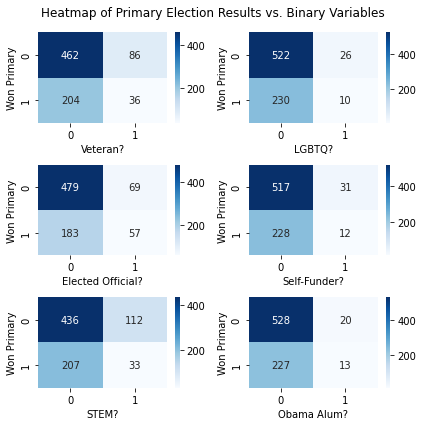

In [107]:
#CODE FOR FIGURE 3
fig = plt.figure(figsize=(6, 6))
fig.suptitle('Heatmap of Primary Election Results vs. Binary Variables')
gs = gridspec.GridSpec(3, 2)
for i, col in enumerate(fav_cols):
  one_one = len(dems[(dems[col] == 1) & (dems['Won Primary'] == 1)])
  one_zero = len(dems[(dems[col] == 1) & (dems['Won Primary'] == 0)])
  zero_one = len(dems[(dems[col] == 0) & (dems['Won Primary'] == 1)])
  zero_zero = len(dems[(dems[col] == 0) & (dems['Won Primary'] == 0)])
  ax = fig.add_subplot(gs[i])
  sns.heatmap([[zero_zero, one_zero], [zero_one, one_one]], annot=True, fmt='d', cmap='Blues', ax=ax)
  ax.set_xlabel(col)
  ax.set_ylabel('Won Primary')
plt.tight_layout()
plt.show()

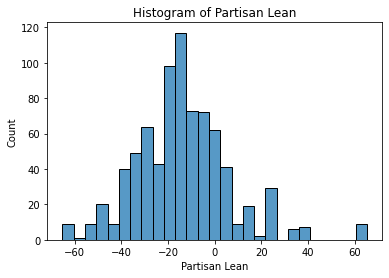

In [108]:
#CODE FOR FIGURE 4
sns.histplot(dems['Partisan Lean'])
plt.title('Histogram of Partisan Lean')
plt.savefig('partisan_lean_hist.png')
plt.show()

In [109]:
num_cols = dems.select_dtypes(include='number').columns
corrs = []
for col in num_cols:
  corr = dems[col].corr(dems['Won Primary'])
  corrs.append(corr)
corr_df = pd.DataFrame({'Feature': num_cols, 'Correlation': corrs})
corr_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
2,Won Primary,1.000000
12,Biden Endorsed?,1.000000
9,Party Support?,0.911477
1,Primary %,0.799496
10,Emily Endorsed?,0.636015
16,PCCC Endorsed?,0.606178
17,Indivisible Endorsed?,0.517078
19,VoteVets Endorsed?,0.454751
13,Sanders Endorsed?,0.419790
18,WFP Endorsed?,0.349106


In [113]:
def estimate_treatment_effect(df, treatment, outcome, features):
  """
  @param treatment: Variable of causal interest.
  @param outcome: Binary outcome.
  @param features: A list of features to use in the model.
  return: Both the calculated and naive estimated treatment effect.
  """

  #Define feature matrix, treatment column, and outcome column
  X = df[features].drop(columns=treatment)
  Z = df[treatment]
  Y = df[outcome]

  #Fit model
  lr = LogisticRegression(penalty=None, max_iter=200, random_state = 42)
  lr.fit(X, Z)

  #Calculate propensity score
  ex = lr.predict_proba(X)[:, 1]

  #Calculate estimated treatment effect
  ete = np.mean(Z * Y / ex) - np.mean((1-Z) * Y / (1-ex))
  return ete

def naive_effect(df, treatment, outcome, features):
  """
  @param treatment: Variable of causal interest.
  @param outcome: Binary outcome.
  @param features: A list of features to use in the model.
  return: The naive estimated treatment effect.
  """
  Y = df[outcome]
  Z = df[treatment]
  #Calculate naive estimated treatment effect, which doesn't take propensity score into account
  naive_est = sum(Y * Z) / sum(Z) - sum(Y * (1-Z)) /(len(Z) - sum(Z))
  return naive_est


In [114]:
#CODE FOR FIGURE 10
np.random.seed(42)
fav_cols = ['Veteran?', 'LGBTQ?', 'Elected Official?', 'Self-Funder?', 'STEM?', 'Obama Alum?', 'Partisan Lean']

#Calculate estimated treatment effect, carried out on the whole DataFrame
eff_whole_df = estimate_treatment_effect(dems, 'STEM?', 'Won Primary', fav_cols)

#Sample DataFrame with replacement and calculate average treatment effect 10000 times
effs = []
for i in np.arange(10000):
  sampled = dems.sample(frac=1, replace=True)
  sample_eff = estimate_treatment_effect(sampled, 'STEM?', 'Won Primary', fav_cols)
  effs.append(sample_eff)

#Calculate confidence intervals of treatment effect
eff_lower_bound = np.percentile(effs, 2.5)
eff_upper_bound = np.percentile(effs, 97.5)
print(f'95% confidence interval of effect of STEM on winning a primary: ({eff_lower_bound}, {eff_upper_bound})')
print(f'Estimated effect of STEM on winning a primary using entire DataFrame: {eff_whole_df}')
naive_est = naive_effect(dems, 'STEM?', 'Won Primary', fav_cols)
print(f'Naive Effect of STEM on winning a primary: {naive_est}')

95% confidence interval of effect of STEM on winning a primary: (-0.1586302013458395, 0.008471597718353594)
Estimated effect of STEM on winning a primary using entire DataFrame: -0.07761117039796014
Naive Effect of STEM on winning a primary: -0.09434225344559444
